<a href="https://colab.research.google.com/github/fnavab/APS360-project/blob/main/Data_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage.interpolation as inter

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
master_path = '/content/gdrive/My Drive/Colab Notebooks/'
folder = 'samples'

Mounted at /content/gdrive


In [3]:
# Import bounding boxes to dictionary

d = {}
with open(master_path+"/samples/list_bbox.txt") as f:
  for i, line in enumerate(f):
    if i != 0 and i != 1: # ignore first two lines
      (key, x1, y1, x2, y2) = line.split()

      #if "Acid_Wash_Ankle_Jeans" in key or "Athletic_Marled_Knit_Joggers" in key or "Basic_Crew_Neck_Tee" in key or "Button_Fly_Denim_Shorts" in key or "Contrast-Trimmed_Sweater" in key: # space saver for now...
      d[key] = (int(x1), int(y1), int(x2), int(y2))

print(len(d))

289222


In [ ]:
#transform = transforms.Compose([transforms.ToTensor()])
#dataset = torchvision.datasets.ImageFolder(root=master_path+folder, transform=transform)

In [4]:
# Need to overwrite default ImageFolder method in torchvision so that we can preserve the filename of the samples

from torchvision import datasets
class ImageFolderWithPaths(datasets.ImageFolder): # https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# instantiate the dataset and dataloader
transform = transforms.Compose([transforms.ToTensor()])
dataset = ImageFolderWithPaths(root=master_path+folder, transform=transform) # our custom dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [5]:
max = 0

for data in dataloader:
  h = data[0].shape[2]
  w = data[0].shape[3]
  if h > max:
    max = h
  if w > max:
    max = w

print(max)

300


In [10]:
def crop_image(img, filename, max_size):
  
  print("Original shape:", img.shape)
  img = img.permute(1, 2, 0) # rearrange tensor so colour channel is at the end
  print("RGB channel moved:", img.shape)

  print("Name:", filename)

  # in bbox file, filenames are formatted like this: img/Sheer_Pleated-Front_Blouse/img_00000001.jpg
  filename = "img/" + filename[49:] # get rid of google drive prefix and replace with "img/"
  print("Modified name:", filename)

  img_name = filename
  x1, y1, x2, y2 = d[img_name] # get bbox values

  img_cropped = img[y1:y2, x1:x2, :3] # crop based on bbox values

  print("Cropped shape:", img_cropped.shape)

  # create background image for uniformly-sized images
  bg = torch.zeros((max_size,max_size,3))

  # superimpose cropped image on background
  for z in range(img_cropped.shape[2]):
    for y in range(img_cropped.shape[1]):
      for x in range(img_cropped.shape[0]):
        bg[x][y][z] = img_cropped[x][y][z]

  # plot original and bounded side by side
  f = plt.figure()
  f.add_subplot(1,3, 1)
  plt.imshow(img)
  f.add_subplot(1,3, 2)
  plt.imshow(img_cropped)
  f.add_subplot(1,3, 3)
  plt.imshow(bg)
  plt.show(block=True)

  return bg

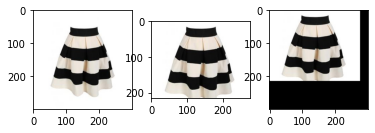

In [33]:
processed_imgs = []

for images, labels, fname in dataloader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, filename, max) # crop image
  processed_imgs.append((processed_img, labels[0])) # add cropped image + label to appropriate class list

In [58]:
# takes in a list of processed images and returns a new list of rotated image
def augment_photos(processed_imgs):
  rotated_imgs = []
  for i in range(len(processed_imgs)):
    angle = np.random.randint(-25, 25)
    rotated_img = inter.rotate(processed_imgs[i][0].numpy(), angle)
    rotated_imgs.append(rotated_img)
  return rotated_imgs

In [59]:
rotated_imgs = augment_photos(processed_imgs)

In [60]:
# Save processed images
torch.save(processed_imgs, "imgs.pt")

In [ ]:
clothing_images = torch.load("imgs.pt")
print(type(clothing_images))

<class 'list'>


torch.utils.data.dataloader.DataLoader
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


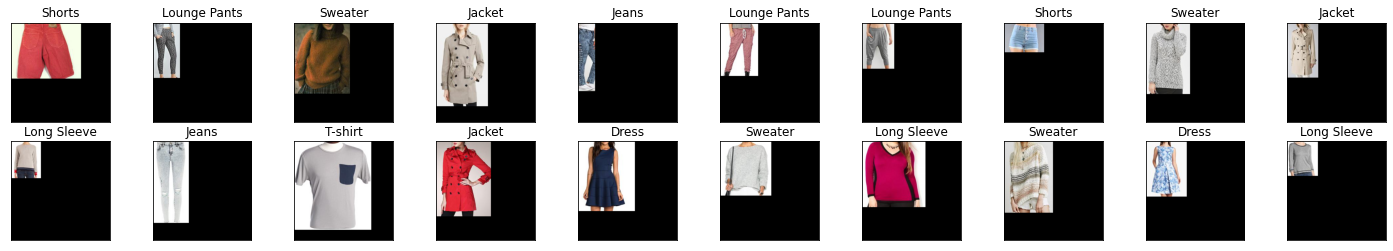

In [ ]:
# test a different batch size
dataloader_32 = torch.utils.data.DataLoader(clothing_images, batch_size=32, shuffle=True)

# obtain one batch of training images
print(type(dataloader_32))
dataiter = iter(dataloader_32)
print(type(dataiter))
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
classes = ["T-shirt", "Long Sleeve", "Jeans", "Lounge Pants", "Shorts", "Skirt", "Sweater", "Dress", "Jacket"]
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    ax.set_title(classes[labels[idx]])